In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

In [10]:
!pip freeze > requirements.txt

# Einlesen

In [2]:
# Einlesen der Daten und Entfernen von nicht benötigten Spalten
data = pd.read_csv("data/Datenakquise DSE2023.csv")
data.drop(data.columns.values[6:12], axis=1, inplace=True)
data.drop(data.columns.values[9:24], axis=1, inplace=True)
data.drop(data.columns.values[0], axis=1, inplace=True)

# Umwandlung der Schärfegrade auf die Text-Antworten (ursprünglich 1-4 + Ja/Nein)
data["Wie scharf essen Sie normalerweise?"][data["Wie scharf essen Sie normalerweise?"] == 1] = "Wahrnehmbar"
data["Wie scharf essen Sie normalerweise?"][data["Wie scharf essen Sie normalerweise?"] == 2] = "Leicht scharf"
data["Wie scharf essen Sie normalerweise?"][data["Wie scharf essen Sie normalerweise?"] == 3]=  "Moderat scharf"
data["Wie scharf essen Sie normalerweise?"][data["Wie scharf essen Sie normalerweise?"] == 4] = "Sehr scharf"
data["Wie scharf essen Sie normalerweise?"] = data["Wie scharf essen Sie normalerweise?"].fillna("Nicht scharf")

# Umwandlung der Spalten auf kategorische Daten
for column in data.columns.values[:7]:
    data[column] = data[column].astype("category")

# Sortierung der Levels, damit die Visualisierung auch passt
data["Wie scharf essen Sie normalerweise?"] = data["Wie scharf essen Sie normalerweise?"].cat.reorder_categories(["Nicht scharf", "Wahrnehmbar", "Leicht scharf", "Moderat scharf", "Sehr scharf"])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 10 columns):
 #   Column                                                     Non-Null Count  Dtype   
---  ------                                                     --------------  -----   
 0   Geschlecht                                                 670 non-null    category
 1   Wie alt sind Sie?                                          670 non-null    category
 2   Bitte wählen Sie Ihre höchste abgeschlossene Ausbildung    670 non-null    category
 3   In welcher Branche sind Sie tätig?                         670 non-null    category
 4   Wo wohnen Sie?                                             670 non-null    category
 5   Essen Sie gerne Essen mit spürbarer Schärfe?               670 non-null    category
 6   Wie scharf essen Sie normalerweise?                        670 non-null    category
 7   Mögen Sie Essen aus den folgenden kulinarischen Regionen?  670 non-null    object  
 8   

C:\Users\basti\AppData\Local\Temp\ipykernel_12336\4080635178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Wie scharf essen Sie normalerweise?"][data["Wie scharf essen Sie normalerweise?"] == 1] = "Wahrnehmbar"


# Analyse

## Essen die verschiedenen Geschlechter gerne scharf?

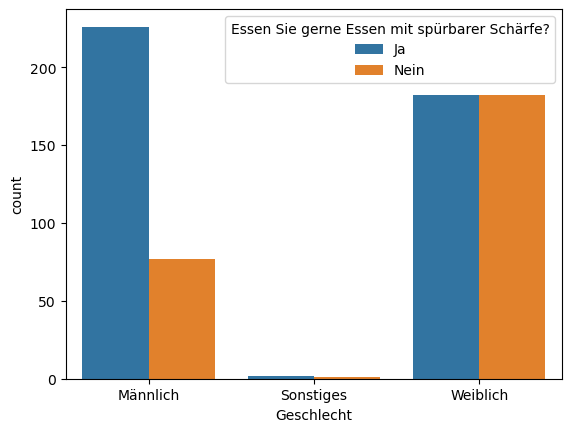

In [3]:
ax = sns.countplot(data, x="Geschlecht", hue="Essen Sie gerne Essen mit spürbarer Schärfe?")

fig = ax.get_figure()
fig.savefig("spicy_gender.png") 

## Essen Männer und Frauen unterschiedlich scharf?

[Text(0, 0, 'Nicht scharf'),
 Text(1, 0, 'Wahrnehmbar'),
 Text(2, 0, 'Leicht scharf'),
 Text(3, 0, 'Moderat scharf'),
 Text(4, 0, 'Sehr scharf')]

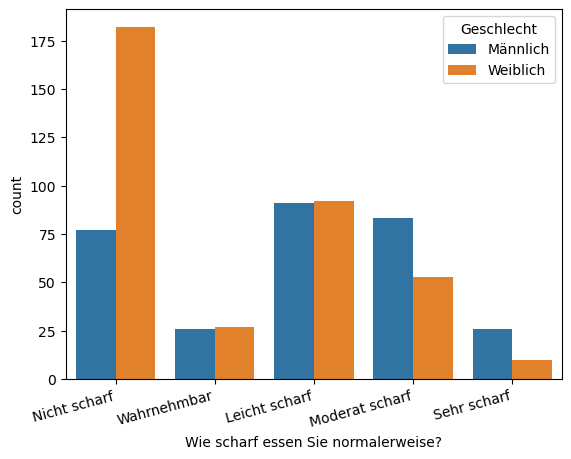

In [4]:
# Sonstiges = nur bei 3 --> ausnehmen
data = data[data["Geschlecht"] != "Sonstiges"]
data.Geschlecht = data.Geschlecht.cat.remove_categories('Sonstiges')

# Vergleich der Schärfegrade zwischen Männern und Frauen
ax = sns.countplot(data, x="Wie scharf essen Sie normalerweise?", hue="Geschlecht")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, horizontalalignment='right')

## Gibt es einen Zusammenhang zw. politischer Ausrichtung und gewünschter Schärfe?

[Text(0.5, 0, 'Libertär (1) - Autoritär (5)'),
 Text(0, 0.5, 'Sozialliberal (1) - Konservativ (5)')]

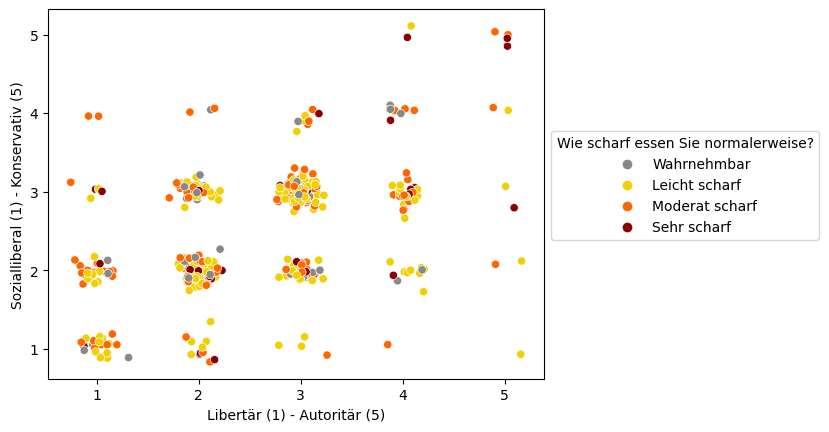

In [5]:
# Helper Funktion für Apply --> Punkt-Größe im Scatterplot abhängig von Anzahl der Vorkommen
# Wurde schlussendlich nicht verwendet.
def calc_size(row):
    return len(data[(data["Wie scharf essen Sie normalerweise?"] == row["Wie scharf essen Sie normalerweise?"]) & (data["Teil 1: Wie ist Ihre politische Einstellung?"] == row["Teil 1: Wie ist Ihre politische Einstellung?"])  & (data["Teil 2: Wie ist Ihre politische Einstellung?"] == row["Teil 2: Wie ist Ihre politische Einstellung?"])])

# Jitter anwenden --> leichte Verschiebung der Punkte für 3D Feel (sonst wäre es auch nicht darstellbar)
def jitter(value):
    return value + np.random.normal(0,0.1)

# Dataframe kopieren und entsprechend bearbeiten
spicy_data = data.copy(deep=True)
spicy_data["spicy_size"] = data.apply(lambda x: calc_size(x), axis=1) # Punktgröße abh. von Anzahl je Gruppe

 # Entfernen der "Nicht scharf" Punkte. Übersichtlichkeit + nur scharfe Interessant.
spicy_data = spicy_data[spicy_data["Wie scharf essen Sie normalerweise?"] != "Nicht scharf"]
spicy_data["Wie scharf essen Sie normalerweise?"] = spicy_data["Wie scharf essen Sie normalerweise?"].cat.remove_categories('Nicht scharf')
spicy_data["Wie scharf essen Sie normalerweise?"] = spicy_data["Wie scharf essen Sie normalerweise?"].cat.reorder_categories(["Wahrnehmbar", "Leicht scharf", "Moderat scharf", "Sehr scharf"])

# Teil 1: Sozialliberal - Konservativ
spicy_data["Teil 1: Wie ist Ihre politische Einstellung?"] = spicy_data["Teil 1: Wie ist Ihre politische Einstellung?"].apply(lambda x: jitter(x))
# Teil 2: Libertär - Autoritär
spicy_data["Teil 2: Wie ist Ihre politische Einstellung?"] = spicy_data["Teil 2: Wie ist Ihre politische Einstellung?"].apply(lambda x: jitter(x))

# Händisch farben bestimmen
colors = ["#888888", "#F0D000", "#FF6600", "#880000"]

sns.set_palette(sns.color_palette(colors))
ax = sns.scatterplot(spicy_data, 
                     x="Teil 1: Wie ist Ihre politische Einstellung?", 
                     y="Teil 2: Wie ist Ihre politische Einstellung?", 
                     #size = "spicy_size",
                     hue="Wie scharf essen Sie normalerweise?", palette=colors)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.69))
ax.set(xlabel='Libertär (1) - Autoritär (5)', ylabel='Sozialliberal (1) - Konservativ (5)')


## Analyse mit kulinarischen Regionen

In [6]:
# Analyse der Regionen:
region_data = data.copy(deep=True)
region_dict = dict()

# Erzeugung eines Dictionaries aus den Daten. Über Zeilen iterieren und entsprechendes Feld bearbeiten
for row in data.iterrows():
    row = row[1]
    opts = re.split(";|,",row[7])
    # Für jede angehakte Box bzw. jede Freitextantwort: ungültige Zeichen filtern + Lowercase
    for opt in opts:
        opt = opt.strip().lower()
        opt = re.sub("[^a-z üäö]", "", opt)
        # Falls leerer String oder ungültiges Wort --> Entfernen
        if len(opt) > 0 and " " not in opt and opt not in ["alle","alles","überall", "uvm","vieles","ja"]:
            if opt not in region_dict.keys():
                region_dict[opt] = 0
            region_dict[opt] += 1
        
# Filtern der Einträge die nur ein paar mal Vorkommen
new_region_dict = {key:value for (key, value) in region_dict.items() if value > 5}
print(len(new_region_dict.keys()))
for region in new_region_dict.keys():
    print(region, new_region_dict[region])
    
# Umwandlung in Multi-Hot encoding: wurde aber schlussendlich doch nicht gebraucht.
def multihot(row, region):
    return 1 if region in row.loc["Mögen Sie Essen aus den folgenden kulinarischen Regionen?"].lower() else 0
    
for region in new_region_dict.keys():
    region_data[region] = region_data.apply(lambda x: multihot(x, region), axis=1)

8
italienisch 644
österreichisch 627
chinesisch 551
mexikanisch 462
indisch 391
thailändisch 371
japanisch 28
griechisch 10


### Entscheiden sich Menschen die (nicht) scharf essen für gewisse kulinarische Regionen?

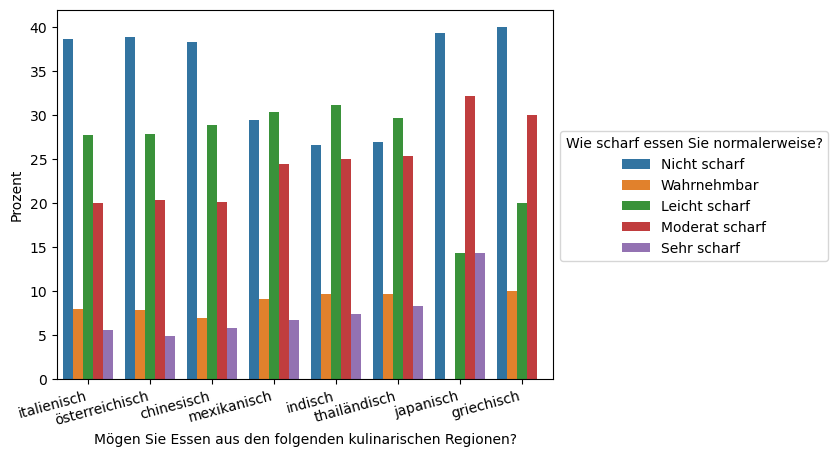

In [7]:
# Nur gewünschte Spalten extrahieren
rd = data.copy(deep=True)
rd = rd[["Wie alt sind Sie?", "Geschlecht", "Wie scharf essen Sie normalerweise?", "Mögen Sie Essen aus den folgenden kulinarischen Regionen?"]]
rd = rd[rd["Geschlecht"] != "Sonstiges"]

df = pd.DataFrame(columns=["Geschlecht", "Wie scharf essen Sie normalerweise?", "Mögen Sie Essen aus den folgenden kulinarischen Regionen?"])

count = 0
for index, row in rd.iterrows():
    elements = re.split(";|,", row[3])
    
    # Calculate statistics only for elements that have been filtered previously
    for element in elements:
        element = element.lower().strip()
        element = re.sub("[^a-z üäö]", "", element)
        # Build new dataframe containing age, gender, spicyness levels and regions
        if element in region_data.keys():
            df_add = pd.DataFrame({
                            "Alter": row[0],
                            "Geschlecht": row[1], 
                            "Wie scharf essen Sie normalerweise?": row[2], 
                            "Mögen Sie Essen aus den folgenden kulinarischen Regionen?": element}, index=[index])
            df = pd.concat([df, df_add])
            count = count+1

# Convert categorical data
df["Mögen Sie Essen aus den folgenden kulinarischen Regionen?"] = df["Mögen Sie Essen aus den folgenden kulinarischen Regionen?"].astype("category")
df["Geschlecht"] = df["Geschlecht"].astype("category")
df["Alter"] = df["Alter"].astype("category")
df["Wie scharf essen Sie normalerweise?"] = df["Wie scharf essen Sie normalerweise?"].astype("category")
df["Wie scharf essen Sie normalerweise?"] = df["Wie scharf essen Sie normalerweise?"].cat.reorder_categories(["Nicht scharf", "Wahrnehmbar", "Leicht scharf", "Moderat scharf", "Sehr scharf"])

# Create plot using value_counts
df_levels = df.groupby("Mögen Sie Essen aus den folgenden kulinarischen Regionen?")["Wie scharf essen Sie normalerweise?"].value_counts(normalize=True).mul(100).rename('Prozent').reset_index()

ax = sns.barplot(data=df_levels, 
                    x="Mögen Sie Essen aus den folgenden kulinarischen Regionen?", 
                    y="Prozent",
                    hue="Wie scharf essen Sie normalerweise?",
                    order=df["Mögen Sie Essen aus den folgenden kulinarischen Regionen?"].value_counts().index,
                    palette="tab10")

ax.set_xticklabels(ax.get_xticklabels(), rotation=15, horizontalalignment='right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.69))

### Hängt die Wahl der Kulinarik vom Alter ab?

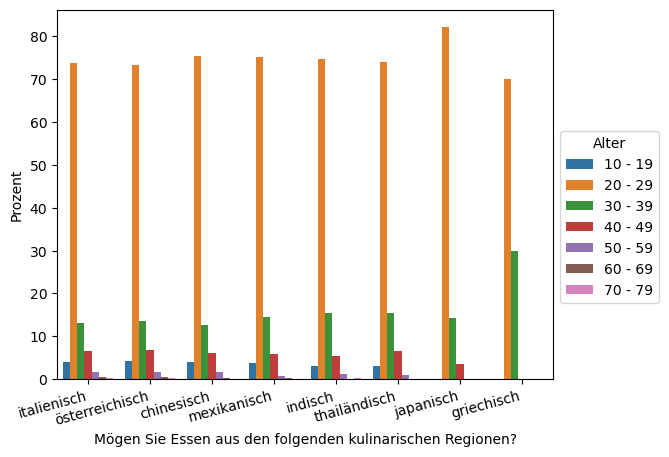

In [8]:
df_age = df.groupby("Mögen Sie Essen aus den folgenden kulinarischen Regionen?")["Alter"].value_counts(normalize=True).mul(100).rename('Prozent').reset_index()
ax = sns.barplot(data=df_age, 
                      x="Mögen Sie Essen aus den folgenden kulinarischen Regionen?", 
                   y="Prozent",
                    hue="Alter",
                  order=df["Mögen Sie Essen aus den folgenden kulinarischen Regionen?"].value_counts().index, palette="tab10")

ax.set_xticklabels(ax.get_xticklabels(), rotation=15, horizontalalignment='right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.69))

## Essen unterschiedliche Altersgruppen unterschiedlich scharf?

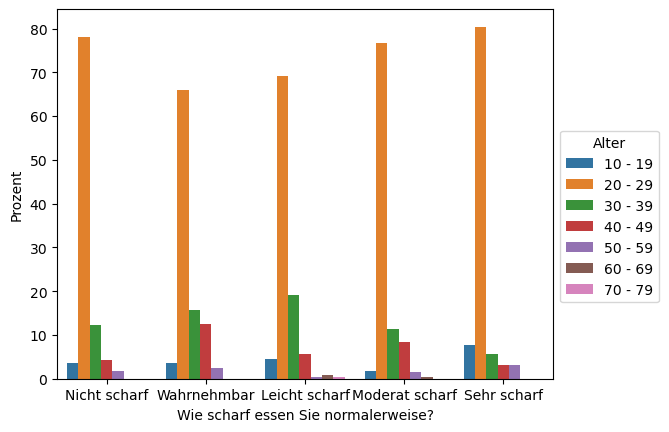

In [9]:
df_agespice = df.groupby("Wie scharf essen Sie normalerweise?")["Alter"].value_counts(normalize=True).mul(100).rename('Prozent').reset_index()

ax = sns.barplot(data=df_agespice, 
                      x="Wie scharf essen Sie normalerweise?", 
                       y="Prozent",
                    hue="Alter", palette="tab10")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.69))